<h1 align="center">Transfer Learning</h1>


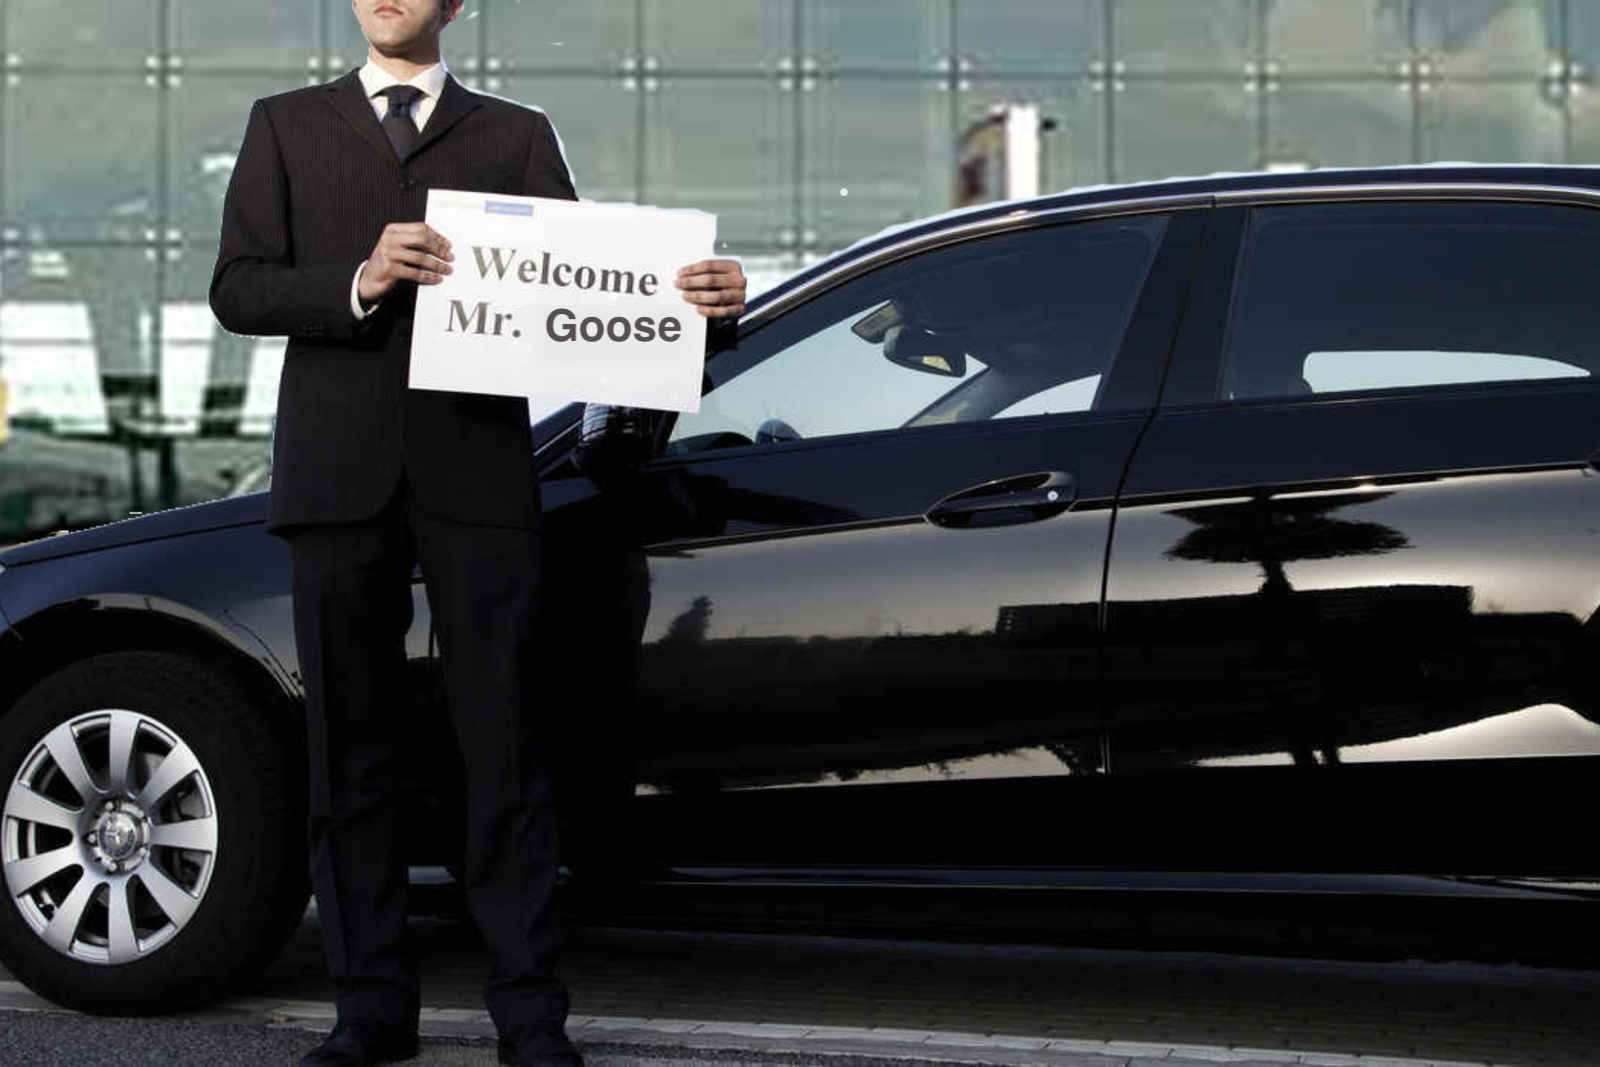

## Чем мы займемся?
Сегодня большинство нейросетей настолько велики, что обучить их с нуля на локальном компьютере или даже небольшом сервере практически невозможно. Техника дообучения(finetuning) основывается на том, что за время своего обучения нейросеть уже успела научиться выделять некоторые глобальные признаки из изображений и для того, чтобы настроиться на новую задачу ей необходимо гораздо меньше времени. Таким образом, данный подход позволяет использовать уже обученную модель с минимальными усилиями, необходимо в течение непродолжительного времени дообучить модель и она будет готова к использования. Мы займемся тем, что рассмотрим различные варианты такого файнтюна.

## Installation

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar xzvf food-101.tar.gz

In [ ]:
!pip install torchvision==0.12

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 61.4 MB/s eta 0:00:0000:0100:01
  Using cached torch-1.11.0-cp39-cp39-manylinux1_x86_64.whl (750.6 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.10.2
    Uninstalling torch-1.10.2:
      Successfully uninstalled torch-1.10.2
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


## Imports

In [24]:
from collections import defaultdict
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle
from typing import Tuple, List

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T, models

from tqdm.notebook import tqdm

from sklearn.metrics import top_k_accuracy_score

from functools import partial

## На чем будем проводить эксперименты?
Наш датасет представляет собой набор фото из 101 класса различных блюд: по 750 фото каждого классса для тренировки и 250 для валидации

In [31]:
train_imgs = []
test_imgs = []
class_to_idx = defaultdict(int)
idx_to_class = defaultdict(str)
class_to_img = defaultdict(list)

### Запишем все метаданные

In [32]:
with open("./food-101/meta/classes.txt", 'r') as classes_f:
    for idx, line in enumerate(classes_f.readlines()):
        class_to_idx[line[:-1]] = idx
        idx_to_class[idx] = line[:-1]
        
with open("./food-101/meta/train.txt", 'r') as train_f:
    for line in train_f.readlines():
        train_imgs.append(line[:-1])
        
with open("./food-101/meta/test.txt", 'r') as test_f:
    for line in test_f.readlines():
        test_imgs.append(line[:-1])

### Выведем несколько случайных изображений

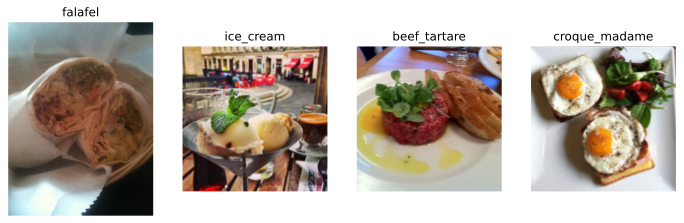

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(12, 12))
for step, img in enumerate(np.random.choice(train_imgs, size=4)):
    ax[step].imshow(Image.open("./food-101/images/" + img + '.jpg'), )
    ax[step].set_title(img[:img.find('/')])
    ax[step].axis('off')
    
plt.show()

## Перейдем непосредственно к обучению, с чем экспериментируем?

**Мы рассмотрим различные архитектуры, отстоящия друг от друга по времени:**
* [VGG](https://arxiv.org/abs/1409.1556)
* [ResNet](https://arxiv.org/abs/1512.03385)
* [ConvNext](https://arxiv.org/abs/2201.03545)

*Коротко об их особенностях: VGG - классическая сверточная архитектура из подряд идущих слоёв свертки и активаций, ResNet - блоковая сверточная архитектура, которая использует идею ResidualConnections, ConvNext - блоковая сверточная архитектура на стероидах, переняла все лучшие черты из сверточных архитектур и Трансформеров.*

**В наших экспериментах мы рассмотрим следующие варианты дообучения сетей:**
* Обучение с нуля только слоя классификатора
* Обучение классификатора с нуля и файнтюн предпоследнего блока с разным темпом обучение
* Обучение классификатора с нуля и файнтюн всей сети с разными темпами обучения

**Как будем сравнивать:**
* Метрикой изберём Top-5 Accuracy, т.к. классов достаточно много
* Сравним результаты внутри каждой архитектуры между собой, посмотрим какой метод файнтюна дает более качественное решение.
* Сравним архитектуры между собой, посмотрим, есть ли большая разница на нашей задаче, какую архитектуру брать.

*Для экспериментов изберем младшие модели каждой из моделей VGG13, ResNet34, ConvNext Tiny*

## Обучение
Зафиксируем параметры для всех экспериментов

### Функционал

In [ ]:
config = {
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu',
    'NUM_WORKERS': 32,
    'BATCH_SIZE': 32,
    'LR': 1e-3,
    'PATH': '.',
    'NUM_EPOCHS': 8
}

Создаем датасеты и даталоадеры

In [ ]:
transform_train = T.Compose([
    T.Resize([224, 224]), # размеры как для  обучения ResNet
    T.RandomHorizontalFlip(p=0.1),  
    T.RandomVerticalFlip(p=0.1), 
    T.ToTensor(), 
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

transform_test = T.Compose([
    T.Resize([224, 224]), # размеры как для  обучения ResNet
    T.ToTensor(), 
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [ ]:
food_set_train = datasets.Food101(root=config['PATH'], split='train', transform=transform_train)
food_set_test = datasets.Food101(root=config['PATH'], split='test', transform=transform_test)

In [ ]:
food_loader_train = DataLoader(
    food_set_train, 
    batch_size=config['BATCH_SIZE'],
    pin_memory=True,
    shuffle=True,
    num_workers=config['NUM_WORKERS']
)
food_loader_test = DataLoader(
    food_set_test, 
    batch_size=config['BATCH_SIZE'],
    pin_memory=True,
    num_workers=config['NUM_WORKERS']
)

Вспомогательная функция для "заморозки" весов сети

In [ ]:
def freeze_model(model) -> nn.Module:
    for parameter in model.parameters():
        parameter.requires_grad = False
    return model

Функция загрузки модели

In [ ]:
def load_model(model_name: str) -> nn.Module:
    if model_name == "vgg":
        model = models.vgg13(pretrained=True)
        model = freeze_model(model)
        model.classifier[6] = nn.Linear(in_features=4096, out_features=101, bias=True)
        for parameter in model.classifier.parameters():
            parameter.requires_grad = True
    if model_name == "resnet":
        model = models.resnet34(pretrained=True)
        model = freeze_model(model)
        model.fc = nn.Linear(in_features=512, out_features=101, bias=True)
    if model_name == "convnext":
        model = models.convnext_tiny(pretrained=True)
        model = freeze_model(model)
        model.classifier[2] = nn.Linear(in_features=768, out_features=101, bias=True)
        for parameter in model.classifier.parameters():
            parameter.requires_grad = True
    return model

Создадим класс для того, чтобы логировать статистики

In [10]:
class Logger:
    def __init__(self, label):
        self.stats = defaultdict(list)
        self.label = label
        
    def __getitem__(self, name: str) -> List:
        return self.stats[name]
    
    def add_stat(self, name: str) -> None:
        self.stats[name] = []
    
    def log(self, new_stats: dict) -> None:
        for name in new_stats:
            self.stats[name].append(new_stats[name])

Функция для вывода графиков

In [85]:
from IPython.display import clear_output
from collections.abc import Iterable


def plot_results(
    loggers: Logger,
    pure_markers=True
)-> None:

    clear_output()

    if  not isinstance(loggers, Iterable):
        loggers = [loggers]

    fig, ax = plt.subplots(2, 2, figsize=(16, 16))
    
    markers = ['p', 'x', '*', '.', 'P', 'X']
    colors  = ['g', 'r', 'c', 'y', 'b', 'm']

    for i, logger in enumerate(loggers):
        ax[0, 0].plot(
            logger['train_loss'], marker=markers[i % 6] if pure_markers else 'o', 
            color=colors[i % 6], label=logger.label, alpha=0.5
        )
        ax[0, 1].plot(
            logger['train_metric'], marker=markers[i % 6] if pure_markers else 'o', 
            color=colors[i % 6], label=logger.label, alpha=0.5
        )
        ax[1, 0].plot(
            logger['test_loss'], marker=markers[i % 6] if pure_markers else 'o', 
            color=colors[i % 6], label=logger.label, alpha=0.5
        )
        ax[1, 1].plot(
            logger['test_metric'], marker=markers[i % 6] if pure_markers else 'o', 
            color=colors[i % 6], label=logger.label, alpha=0.5
        )
    
    for i in range(2):
        for j in range(2):
            ax[i, j].grid(True)
    
    ax[0, 0].set_xlabel('Log step')
    ax[0, 1].set_xlabel('Log step')
    ax[1, 0].set_xlabel('Validation step')
    ax[1, 1].set_xlabel('Validation step')
    
    ax[0, 0].set_ylabel('Loss')
    ax[0, 1].set_ylabel('Metric')
    ax[1, 0].set_ylabel('Loss')
    ax[1, 1].set_ylabel('Metric')

    ax[0, 0].legend()
    ax[0, 1].legend()
    ax[1, 0].legend()
    ax[1, 1].legend()
    plt.show()

Функция для обработки одного батча данных

In [26]:
def work_batch(
    model: nn.Module, 
    criterion: nn.Module,
    batch: torch.Tensor, 
    device: str
) -> Tuple[torch.Tensor]:
    
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    logits = model(images)

    loss = criterion(logits, labels)
    
    return loss, logits, labels

Функция тренировки одной эпохи

In [27]:
def train_epoch(
    model: nn.Module, 
    criterion: nn.Module,
    optim: torch.optim, 
    train_loader: DataLoader,
    test_loader: DataLoader,
    metric: any,
    device: str,
    logger: Logger,
    log_step: int=None,
    valid_step: int=None,
    scheduler: torch.optim.lr_scheduler=None
):
    if log_step is None:
        log_step = train_loader.__len__() // 100
    
    if valid_step is None:
        valid_step = train_loader.__len__() // 4
    
    train_acc, train_loss = [], []

    for step, batch in tqdm(enumerate(train_loader)):
        loss, logits, labels = work_batch(model, criterion, batch, device)
        
        loss.backward()
        
        optim.step()
        if scheduler is not None:
            scheduler.step()
            
        optim.zero_grad()
        
        train_acc.append(metric(labels.cpu(), logits.detach().cpu().numpy()))
        train_loss.append(loss.detach().cpu().numpy())
        
        if step % log_step == 0:
            logger.log({
                'train_loss': np.mean(train_loss),
                'train_metric': np.mean(train_acc)
            })
            
            train_acc, train_loss = [], []
            
            plot_results(logger)
        
        if step % valid_step == 0:
            with torch.no_grad():
                model.eval()
                metrics, losses = [], []
                for batch in tqdm(test_loader):
                    loss, logits, labels = work_batch(model, criterion, batch, device)
                
                    metrics.append(metric(labels.cpu(), logits.detach().cpu().numpy()))
                    losses.append(loss.detach().cpu().numpy())
                logger.log({
                        'test_loss': np.mean(losses),
                        'test_metric': np.mean(metrics)
                })
                model.train()
            plot_results(logger)

### Попробуем тренировать "с нуля" классификатор и заморозим веса сети 

#### VGG

In [ ]:
model = load_model("vgg")
model = model.to(config['DEVICE'])
for param in model.classifier.parameters():
    param.required_grad = False
for param in model.classifier[6].parameters():
    param.required_grad = True
optim = torch.optim.Adam(model.classifier[6].parameters(), lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_vgg_1 = Logger('VGG')
logger_vgg_1.add_stat('train_loss')
logger_vgg_1.add_stat('train_metric')
logger_vgg_1.add_stat('test_loss')
logger_vgg_1.add_stat('test_metric')

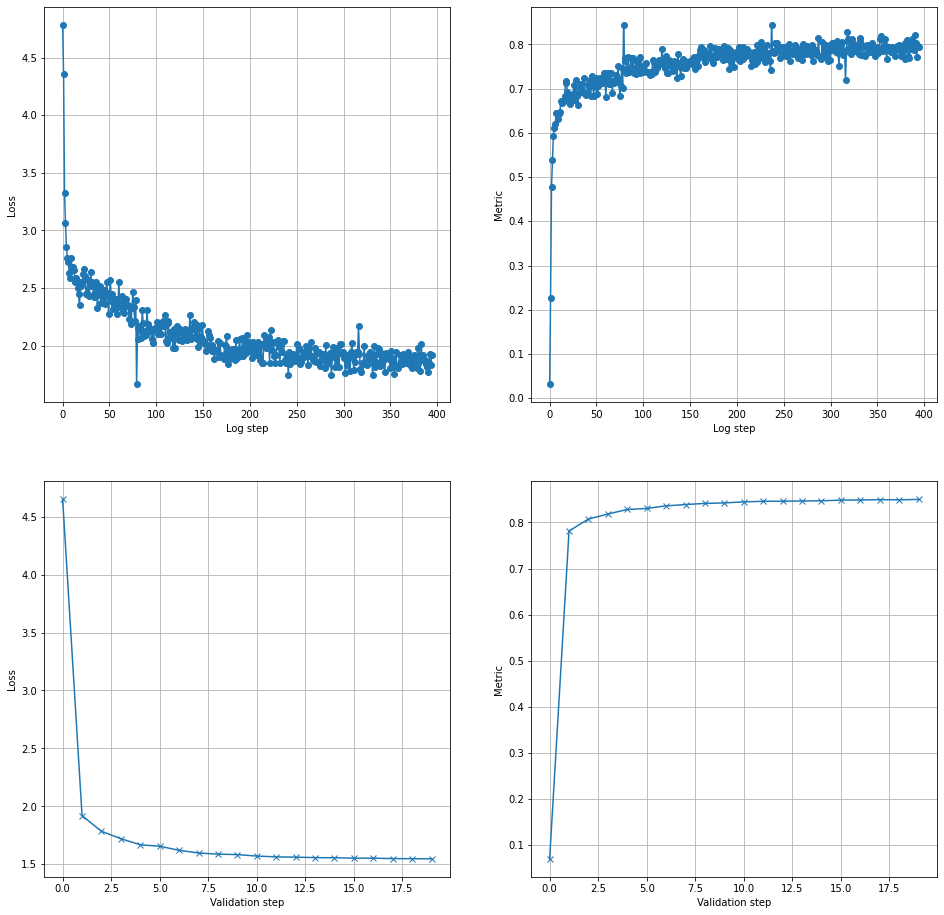

In [ ]:
for epoch in range(config['NUM_EPOCHS']):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_vgg_1,
        log_step = 30,
        scheduler=scheduler
    )

In [ ]:
with open('logger_vgg','wb') as f:
    pickle.dump(logger_vgg.stats, f )

#### ConvNext

In [ ]:
model = load_model("convnext")
model = model.to(config['DEVICE'])
optim = torch.optim.Adam(model.classifier.parameters(), lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_convnext = Logger('ConvNext')
logger_convnext.add_stat('train_loss')
logger_convnext.add_stat('train_metric')
logger_convnext.add_stat('test_loss')
logger_convnext.add_stat('test_metric')

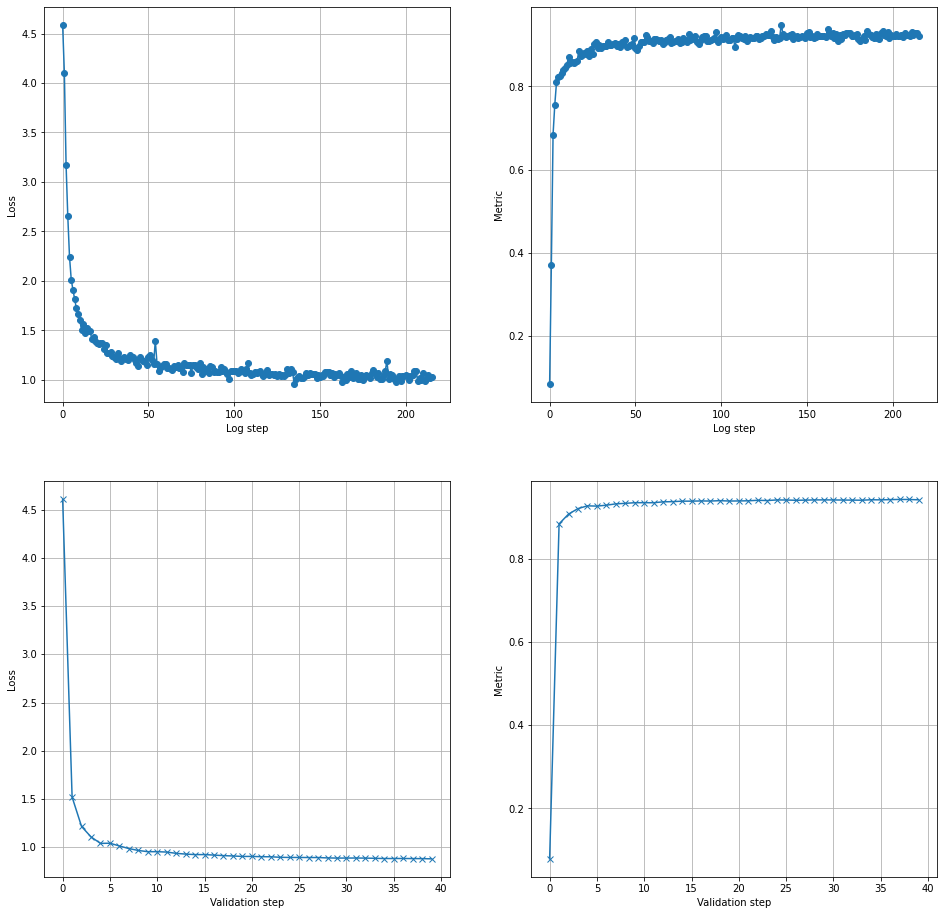

In [ ]:
for epoch in range(config['NUM_EPOCHS']):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_convnext,
        log_step = 30,
        scheduler=scheduler
    )

In [ ]:
with open('logger_convnext','wb') as f:
    pickle.dump(logger_convnext.stats, f )

#### ResNet

In [ ]:
model = load_model("resnet")
model = model.to(config['DEVICE'])
optim = torch.optim.Adam(model.fc.parameters(), lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_resnet = Logger('ResNet')
logger_resnet.add_stat('train_loss')
logger_resnet.add_stat('train_metric')
logger_resnet.add_stat('test_loss')
logger_resnet.add_stat('test_metric')

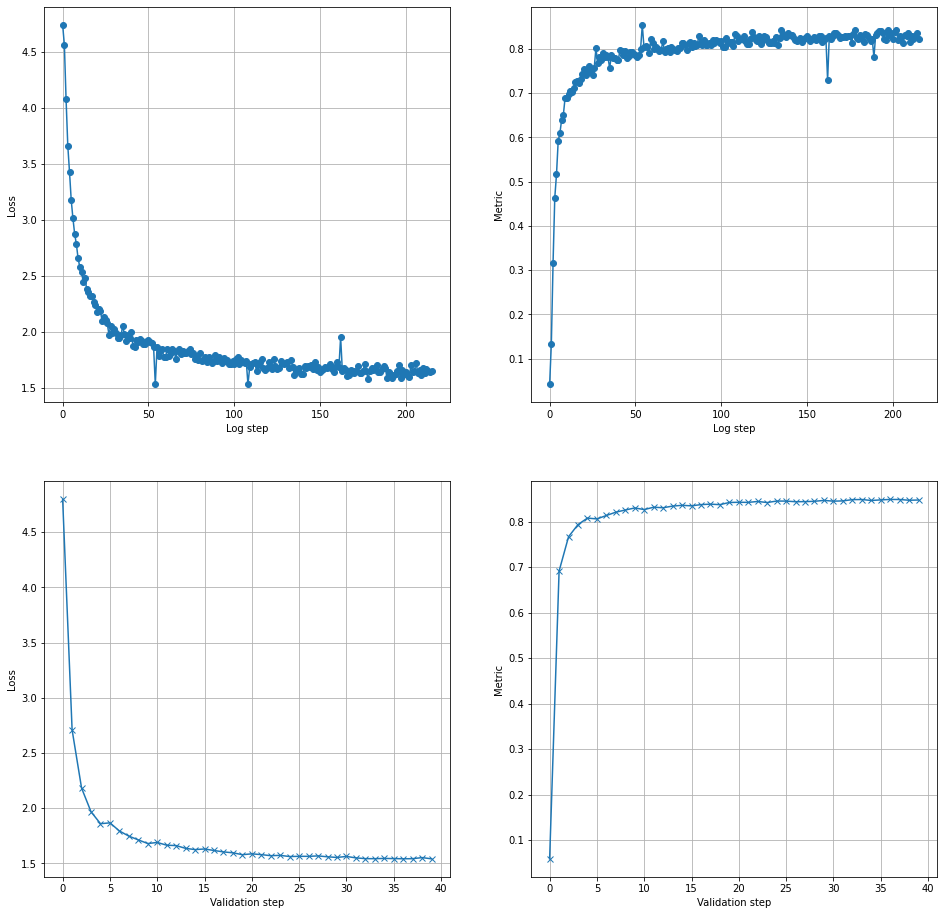

In [ ]:
for epoch in range(config['NUM_EPOCHS']):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_resnet,
        log_step = 30,
        scheduler=scheduler
    )

In [ ]:
with open('logger_resnet','wb') as f:
    pickle.dump(logger_resnet.stats, f )

#### Cравним архитектуры между собой

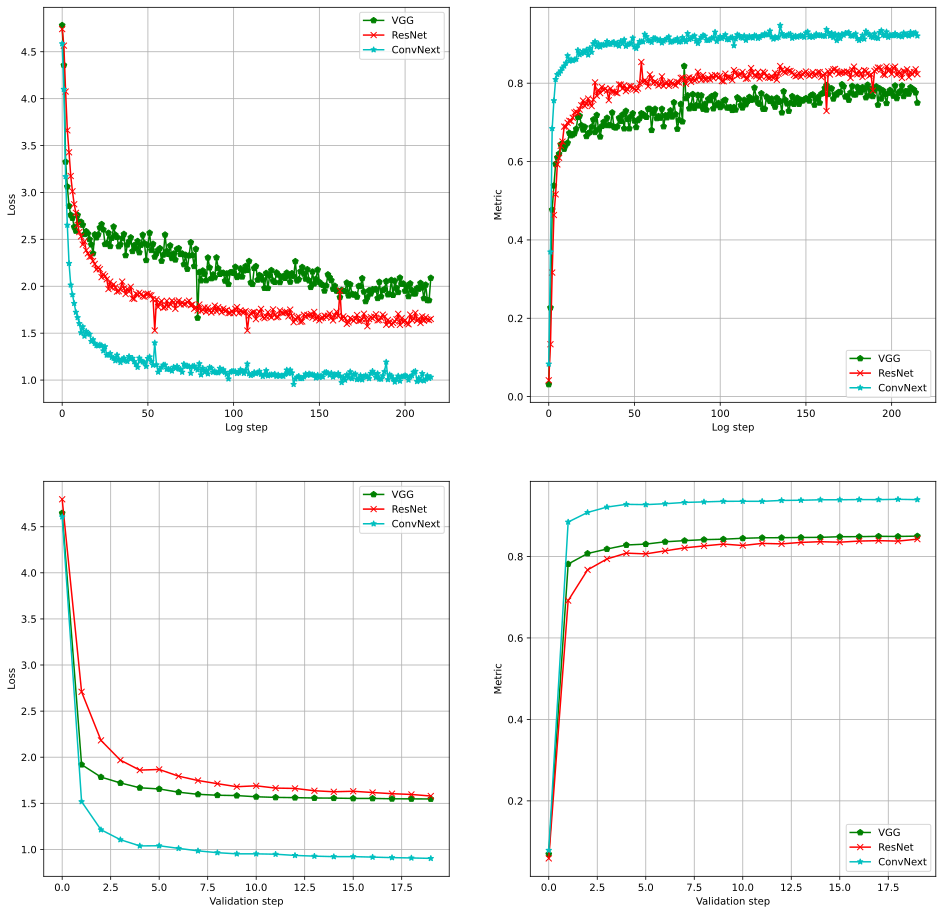

In [39]:
plot_results([logger_vgg, logger_resnet, logger_convnext])

### Попробуем разморозить последний блок перед классификатором.

#### VGG

In [ ]:
model = load_model("vgg")
model = model.to(config['DEVICE'])
optim = torch.optim.Adam(model.classifier.parameters(), lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_vgg = Logger('VGG')
logger_vgg.add_stat('train_loss')
logger_vgg.add_stat('train_metric')
logger_vgg.add_stat('test_loss')
logger_vgg.add_stat('test_metric')

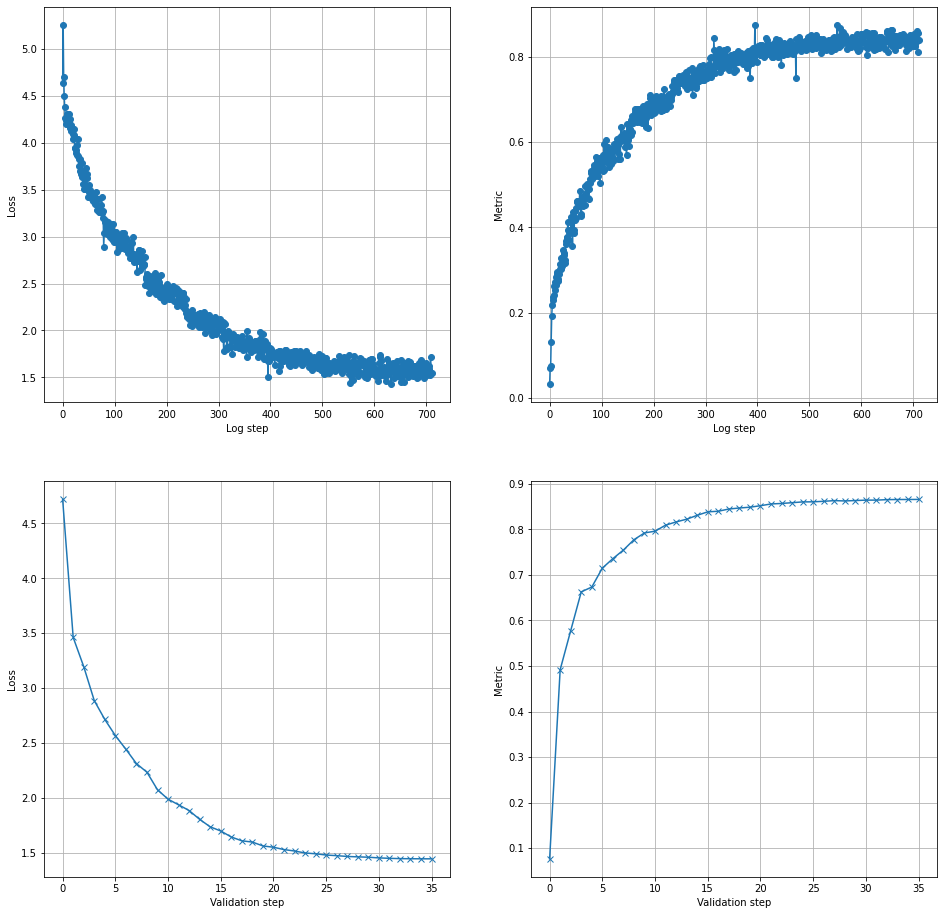

In [ ]:
for epoch in range(config['NUM_EPOCHS']):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_vgg,
        log_step = 30,
        scheduler=scheduler
    )

In [ ]:
with open('logger_vgg','wb') as f:
    pickle.dump(logger_vgg.stats, f )

#### ConvNext

In [ ]:
model = load_model("convnext")
for param in model.features[7].parameters():
    param.required_grad = True
model = model.to(config['DEVICE'])
optim = torch.optim.Adam([{'params': model.features[7].parameters()}, 
                          {'params': model.classifier.parameters()}], lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_convnext_1 = Logger('ConvNext')
logger_convnext_1.add_stat('train_loss')
logger_convnext_1.add_stat('train_metric')
logger_convnext_1.add_stat('test_loss')
logger_convnext_1.add_stat('test_metric')

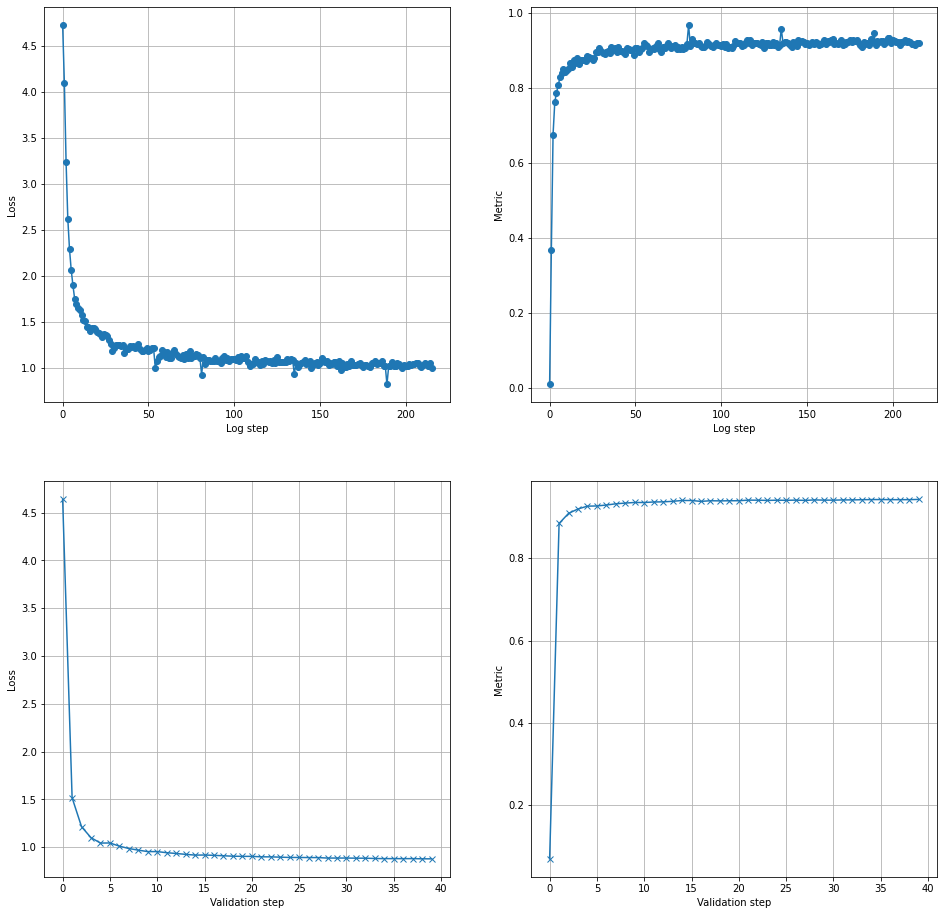

In [ ]:
for epoch in range(config['NUM_EPOCHS']):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_convnext_1,
        log_step = 30,
        scheduler=scheduler
    )

In [ ]:
with open('logger_convnext_1','wb') as f:
    pickle.dump(logger_convnext_1.stats, f )

#### Resnet

In [ ]:
model = load_model("resnet")
for param in model.layer4.parameters():
    param.required_grad = True
model = model.to(config['DEVICE'])
optim = torch.optim.Adam([{'params': model.layer4.parameters()}, 
                          {'params': model.fc.parameters()}], lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_resnet_1 = Logger('ResNet')
logger_resnet_1.add_stat('train_loss')
logger_resnet_1.add_stat('train_metric')
logger_resnet_1.add_stat('test_loss')
logger_resnet_1.add_stat('test_metric')

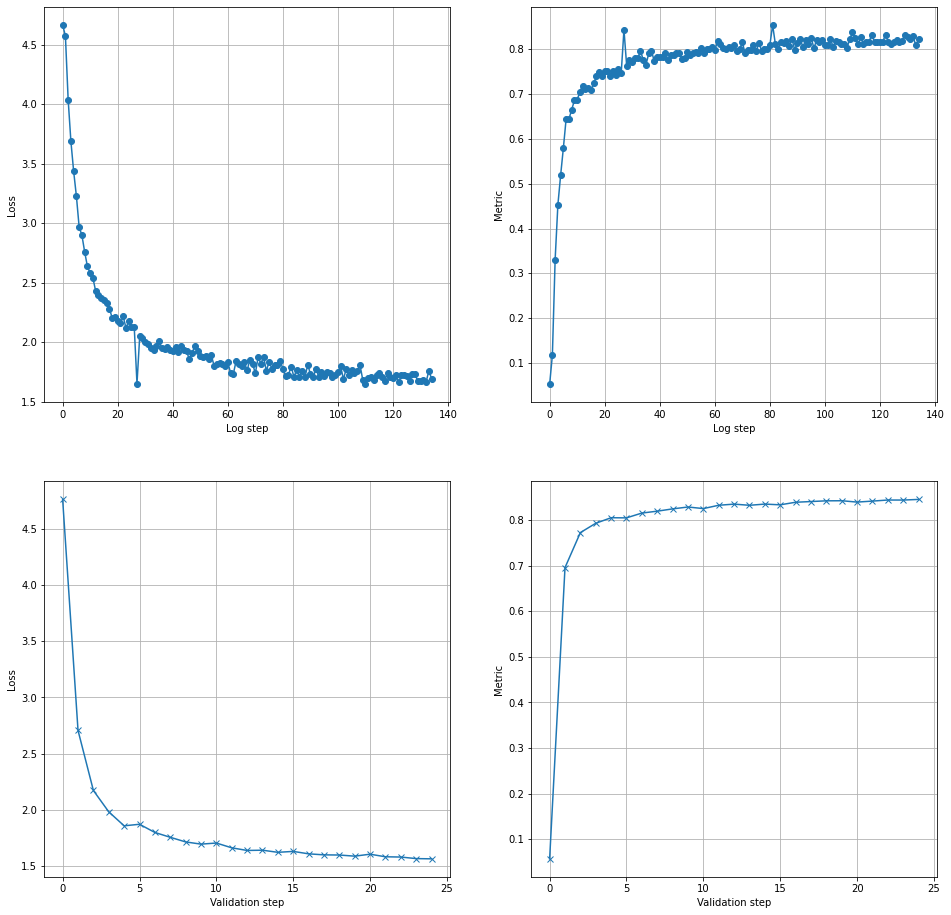

In [ ]:
for epoch in range(config['NUM_EPOCHS']):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_resnet_1,
        log_step = 30,
        scheduler=scheduler
    )

In [ ]:
with open('logger_resnet_1','wb') as f:
    pickle.dump(logger_resnet_1.stats, f )

#### Сравним архитектуры между собой

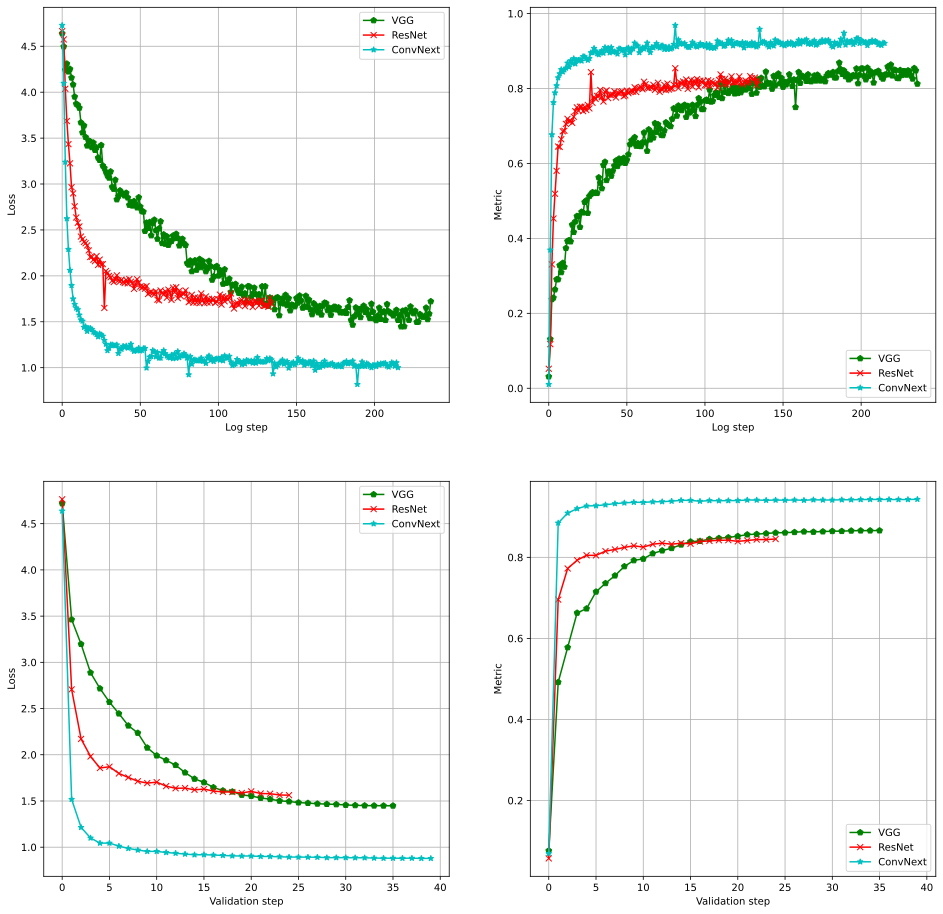

In [53]:
plot_results([logger_vgg_1, logger_resnet_1, logger_convnext_1])

### Попробуем разные уменьшить LR для более глубокого слоя

#### ConvNext

In [ ]:
model = load_model("convnext")
for param in model.features[7].parameters():
    param.required_grad = True
model = model.to(config['DEVICE'])
optim = torch.optim.Adam([{'params': model.features[7].parameters(), 'lr':config["LR"] / 10}, 
                          {'params': model.classifier.parameters()}], lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_convnext_2 = Logger('ConvNext')
logger_convnext_2.add_stat('train_loss')
logger_convnext_2.add_stat('train_metric')
logger_convnext_2.add_stat('test_loss')
logger_convnext_2.add_stat('test_metric')

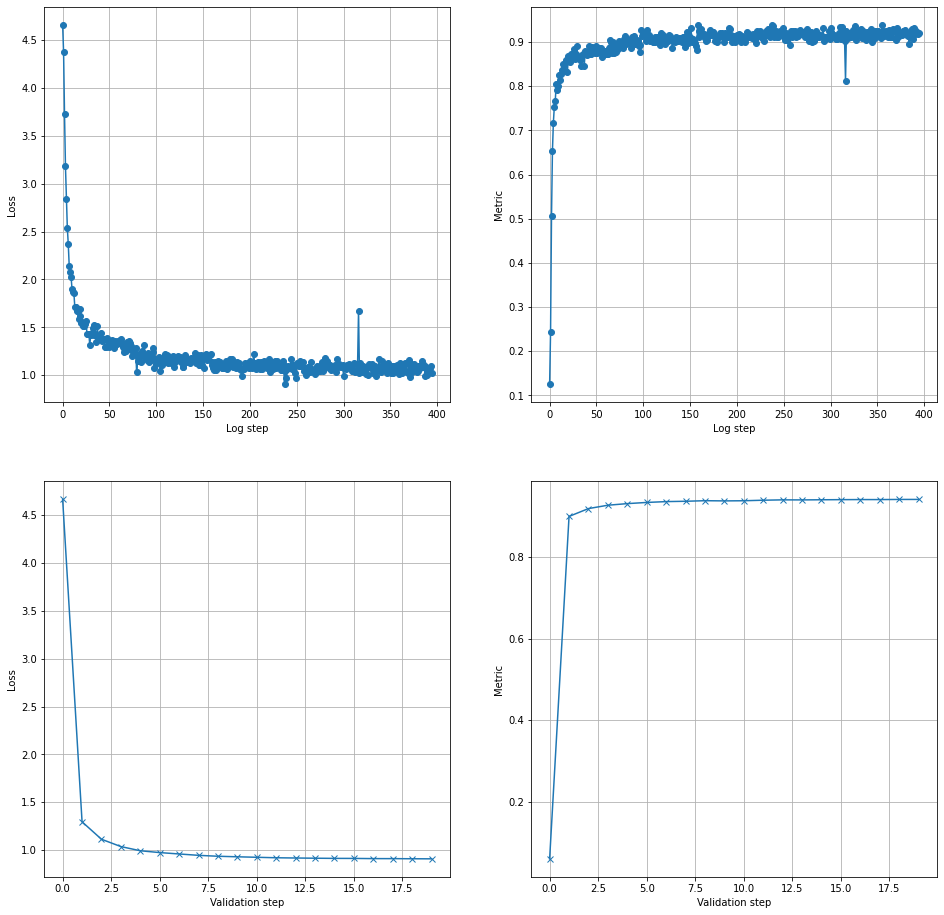

In [ ]:
for epoch in range(config['NUM_EPOCHS']):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_convnext_2,
        log_step = 30,
        scheduler=scheduler
    )

In [ ]:
with open('logger_convnext_2','wb') as f:
    pickle.dump(logger_convnext_2.stats, f )

#### ResNet

In [ ]:
model = load_model("resnet")
for param in model.layer4.parameters():
    param.required_grad = True
model = model.to(config['DEVICE'])
optim = torch.optim.Adam([{'params': model.layer4.parameters(),'lr': config["LR"] / 10}, 
                          {'params': model.fc.parameters()}], lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_resnet_2 = Logger('ResNet')
logger_resnet_2.add_stat('train_loss')
logger_resnet_2.add_stat('train_metric')
logger_resnet_2.add_stat('test_loss')
logger_resnet_2.add_stat('test_metric')

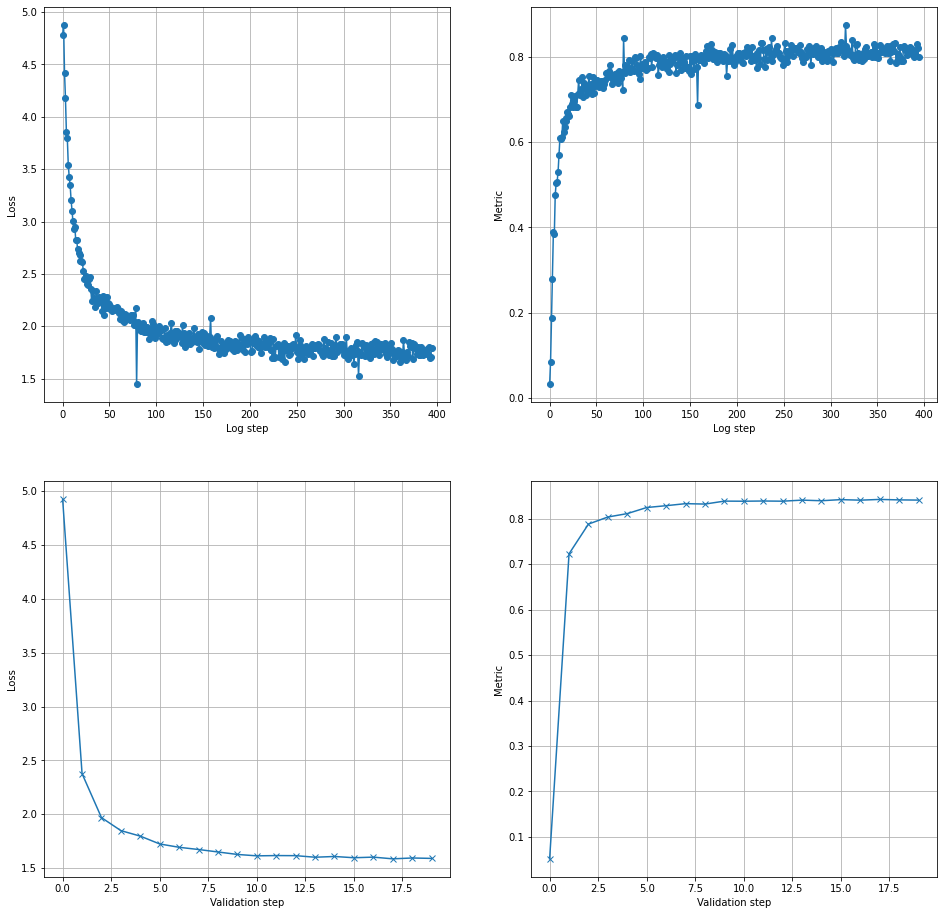

In [ ]:
for epoch in range(config['NUM_EPOCHS']):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_resnet_2,
        log_step = 30,
        scheduler=scheduler
    )

In [ ]:
with open('logger_resnet_2','wb') as f:
    pickle.dump(logger_resnet_2.stats, f )

#### VGG

In [ ]:
model = load_model("vgg")
for param in model.classifier.parameters():
    param.required_grad = True
model = model.to(config['DEVICE'])
optim = torch.optim.Adam([{'params': [*model.classifier[0].parameters(), *model.classifier[3].parameters()],'lr': config["LR"] / 10}, 
                          {'params': model.classifier[6].parameters()}], lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_vgg_2 = Logger('VGG')
logger_vgg_2.add_stat('train_loss')
logger_vgg_2.add_stat('train_metric')
logger_vgg_2.add_stat('test_loss')
logger_vgg_2.add_stat('test_metric')

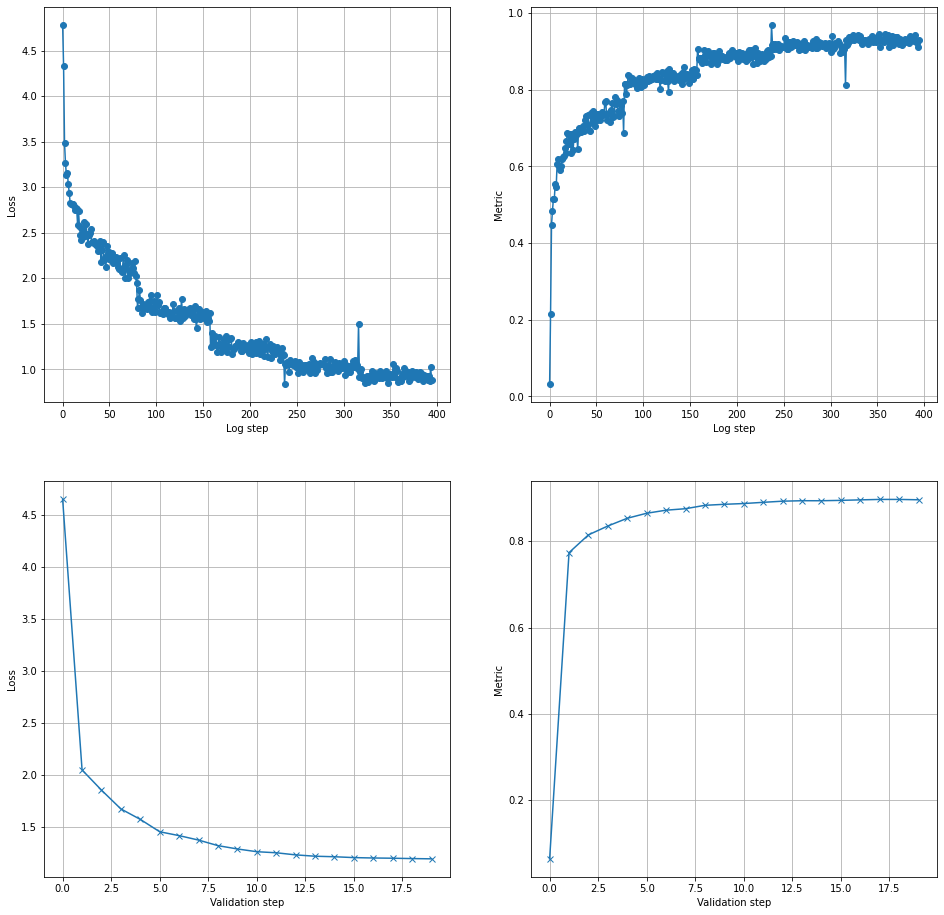

In [ ]:
for epoch in range(config['NUM_EPOCHS']):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_vgg_2,
        log_step = 30,
        scheduler=scheduler
    )

In [ ]:
with open('logger_vgg_2','wb') as f:
    pickle.dump(logger_vgg_2.stats, f )

#### Сравним архитектуры между собой

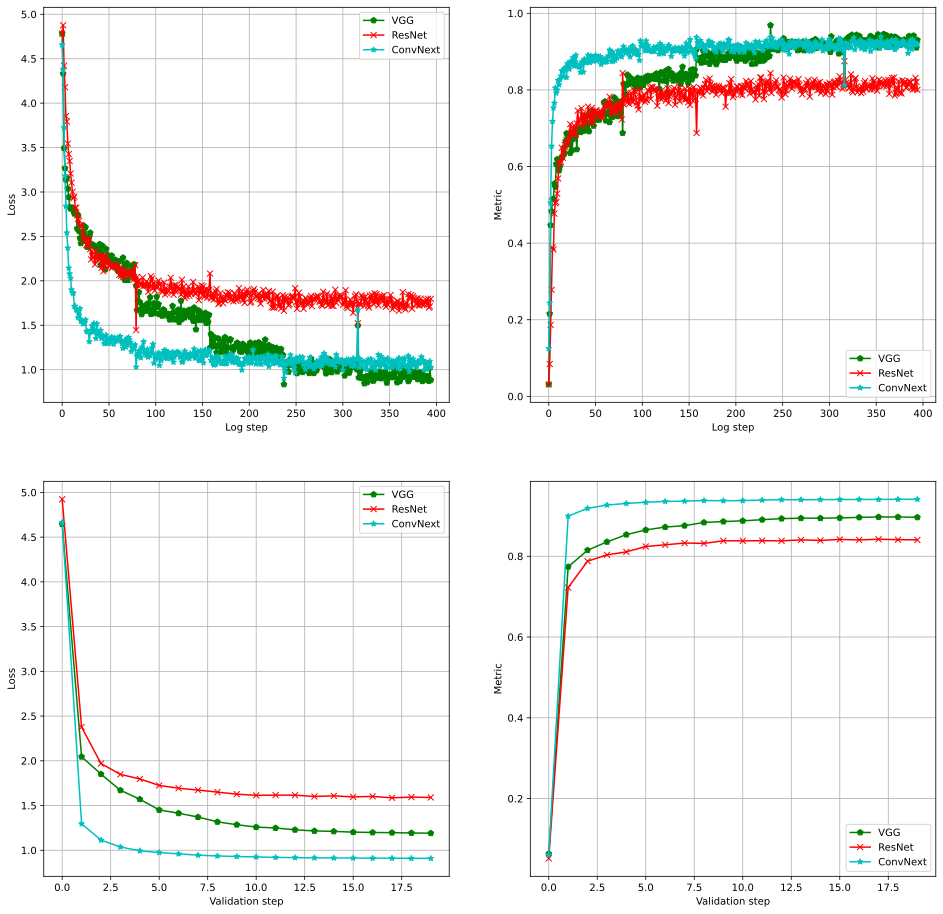

In [57]:
plot_results([logger_vgg_2, logger_resnet_2, logger_convnext_2])

### Затюним всю модель целиком

#### VGG

In [ ]:
model = load_model("vgg")
for param in model.parameters():
    param.required_grad = True
model = model.to(config['DEVICE'])
optim = torch.optim.Adam(model.parameters(), lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_vgg_3 = Logger('VGG')
logger_vgg_3.add_stat('train_loss')
logger_vgg_3.add_stat('train_metric')
logger_vgg_3.add_stat('test_loss')
logger_vgg_3.add_stat('test_metric')

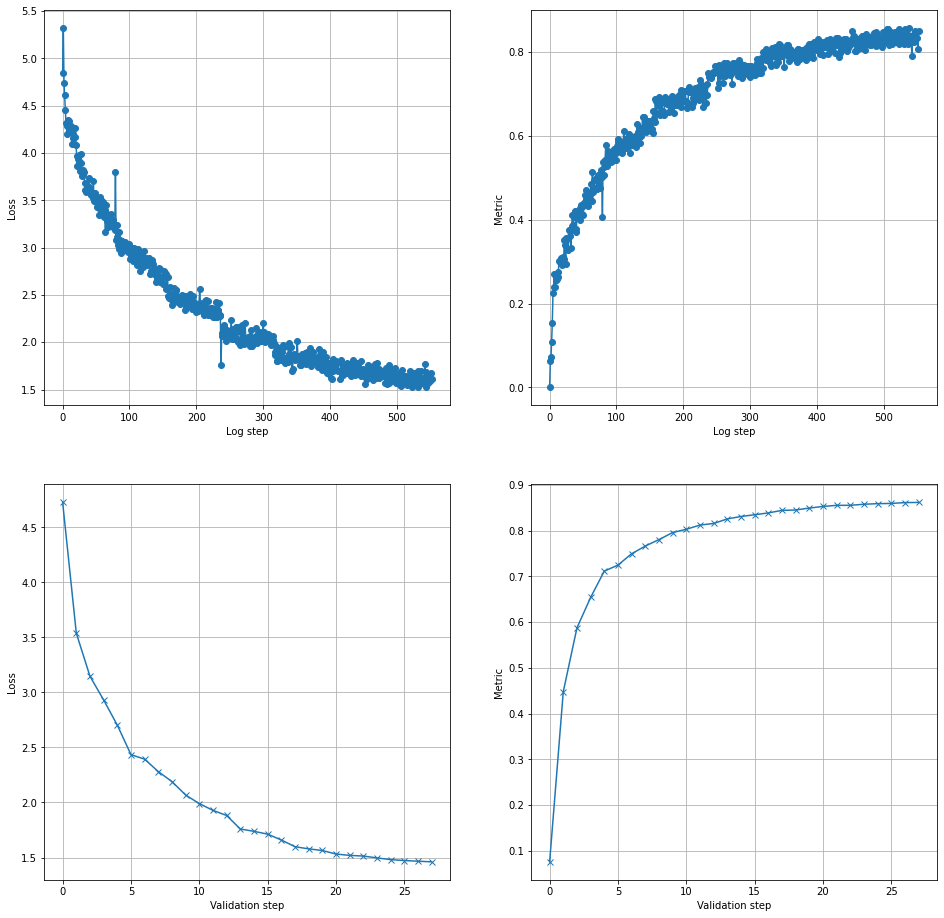

In [ ]:
for epoch in range(config['NUM_EPOCHS']):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_vgg_3,
        log_step = 30,
        scheduler=scheduler
    )

In [ ]:
with open('logger_vgg_3','wb') as f:
    pickle.dump(logger_vgg_3.stats, f )

#### ResNet

In [ ]:
model = load_model("resnet")
for param in model.parameters():
    param.required_grad = True
model = model.to(config['DEVICE'])
optim = torch.optim.Adam(model.parameters(), lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_resnet_3 = Logger('ResNet')
logger_resnet_3.add_stat('train_loss')
logger_resnet_3.add_stat('train_metric')
logger_resnet_3.add_stat('test_loss')
logger_resnet_3.add_stat('test_metric')

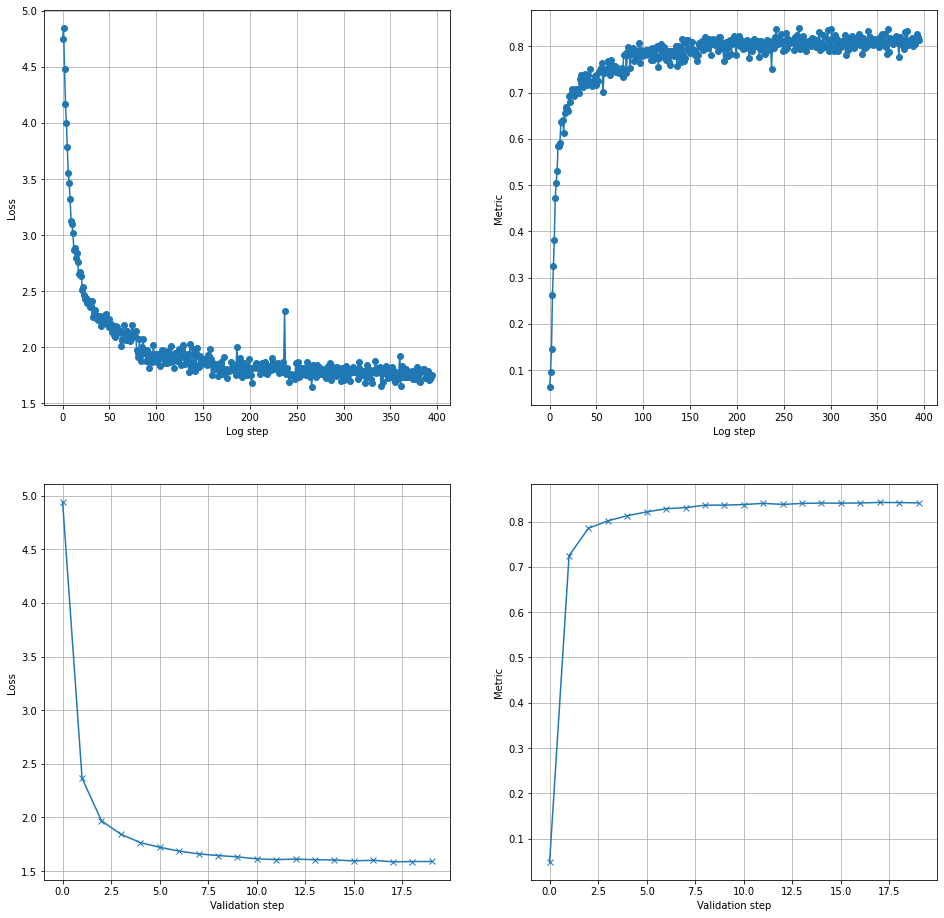

In [ ]:
for epoch in range(config['NUM_EPOCHS']):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_resnet_3,
        log_step = 30,
        scheduler=scheduler
    )

In [ ]:
with open('logger_resnet_3','wb') as f:
    pickle.dump(logger_resnet_3.stats, f )

#### ConvNext

In [ ]:
model = load_model("convnext")
for param in model.parameters():
    param.required_grad = True
model = model.to(config['DEVICE'])
optim = torch.optim.Adam(model.parameters(), lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_convnext_3 = Logger('ConvNext')
logger_convnext_3.add_stat('train_loss')
logger_convnext_3.add_stat('train_metric')
logger_convnext_3.add_stat('test_loss')
logger_convnext_3.add_stat('test_metric')

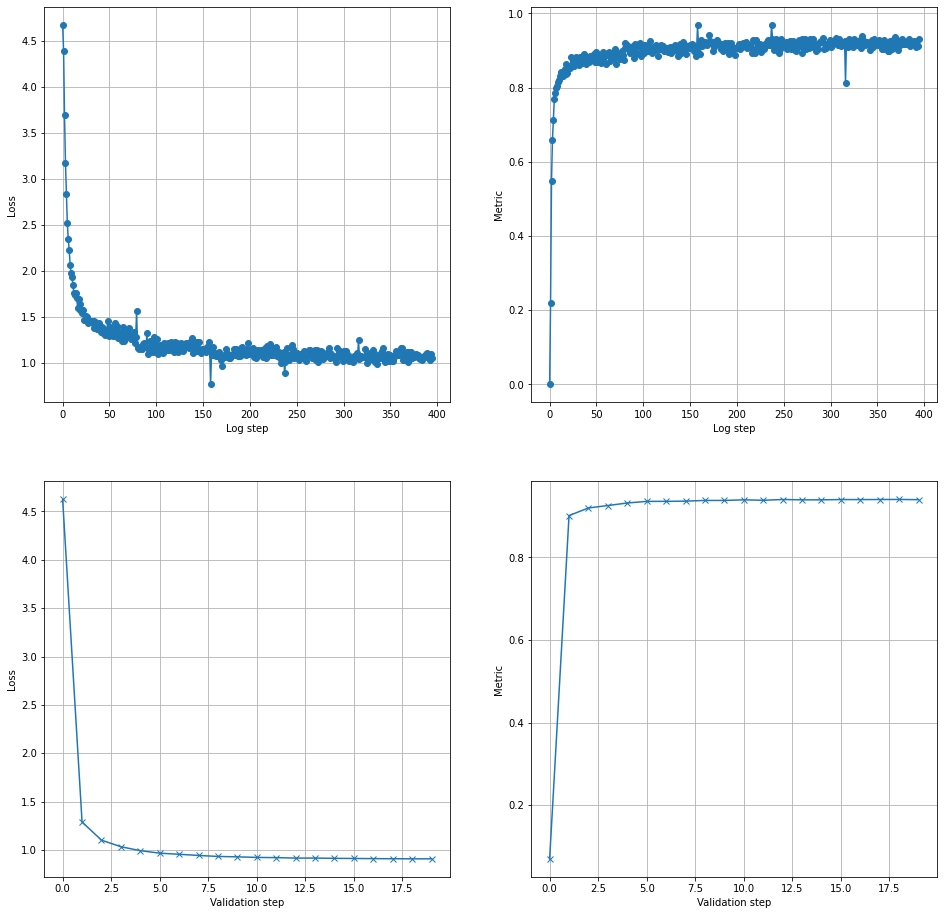

In [ ]:
for epoch in range(config['NUM_EPOCHS']):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_convnext_3,
        log_step = 30,
        scheduler=scheduler
    )

In [ ]:
with open('logger_convnext_3','wb') as f:
    pickle.dump(logger_convnext_3.stats, f )

#### Cравним архитектуры между собой

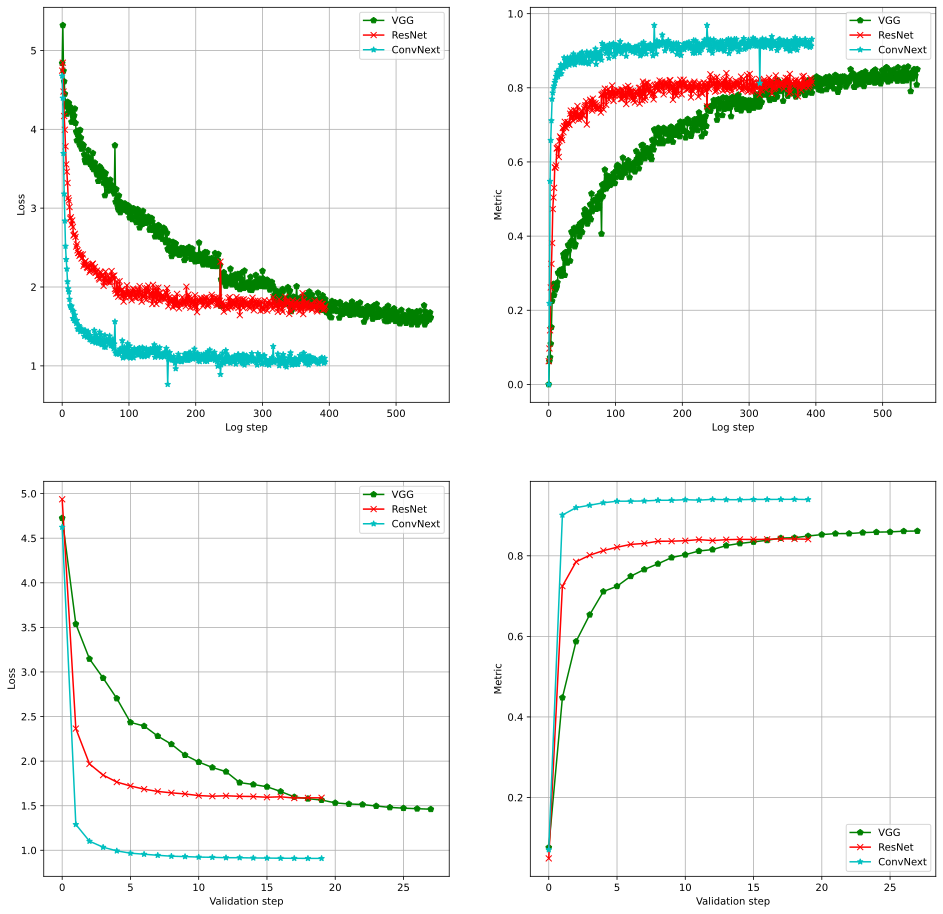

In [63]:
plot_results([logger_vgg_3, logger_resnet_3, logger_convnext_3])

### Попробуем разные LR для feature extractor'a и классификатора, уменьшим темп обучения основной части модели в 10 раз.

#### ConvNext

In [ ]:
model = load_model("convnext")
for param in model.parameters():
    param.required_grad = True
model = model.to(config['DEVICE'])
optim = torch.optim.Adam([{'params': model.features.parameters(), 'lr': config["LR"] / 10}, 
                         {'params': model.classifier.parameters()}], lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_convnext_4 = Logger('ConvNext')
logger_convnext_4.add_stat('train_loss')
logger_convnext_4.add_stat('train_metric')
logger_convnext_4.add_stat('test_loss')
logger_convnext_4.add_stat('test_metric')

In [ ]:
with open('logger_convnext_4','wb') as f:
    pickle.dump(logger_convnext_4.stats, f )

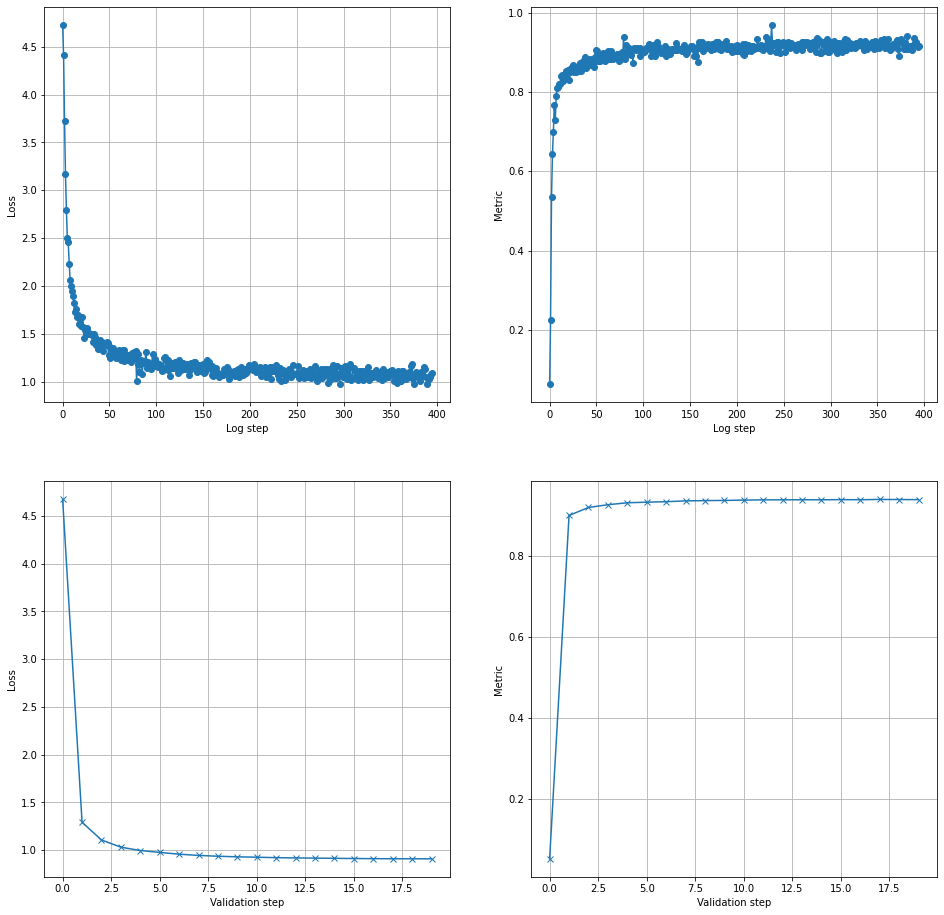

In [ ]:
for epoch in range(config['NUM_EPOCHS']):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_convnext_4,
        log_step = 30,
        scheduler=scheduler
    )

#### ResNet

In [ ]:
model = load_model("resnet")

feature_extract = []
for name, param in model.named_parameters():
    if name[:2] != 'fc':
        feature_extract.append(param)
        
for param in model.parameters():
    param.required_grad = True
model = model.to(config['DEVICE'])

optim = torch.optim.Adam([{'params': feature_extract, 'lr':config["LR"] / 10}, 
                          {'params': model.fc.parameters()}], lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_resnet_4 = Logger('ResNet')
logger_resnet_4.add_stat('train_loss')
logger_resnet_4.add_stat('train_metric')
logger_resnet_4.add_stat('test_loss')
logger_resnet_4.add_stat('test_metric')

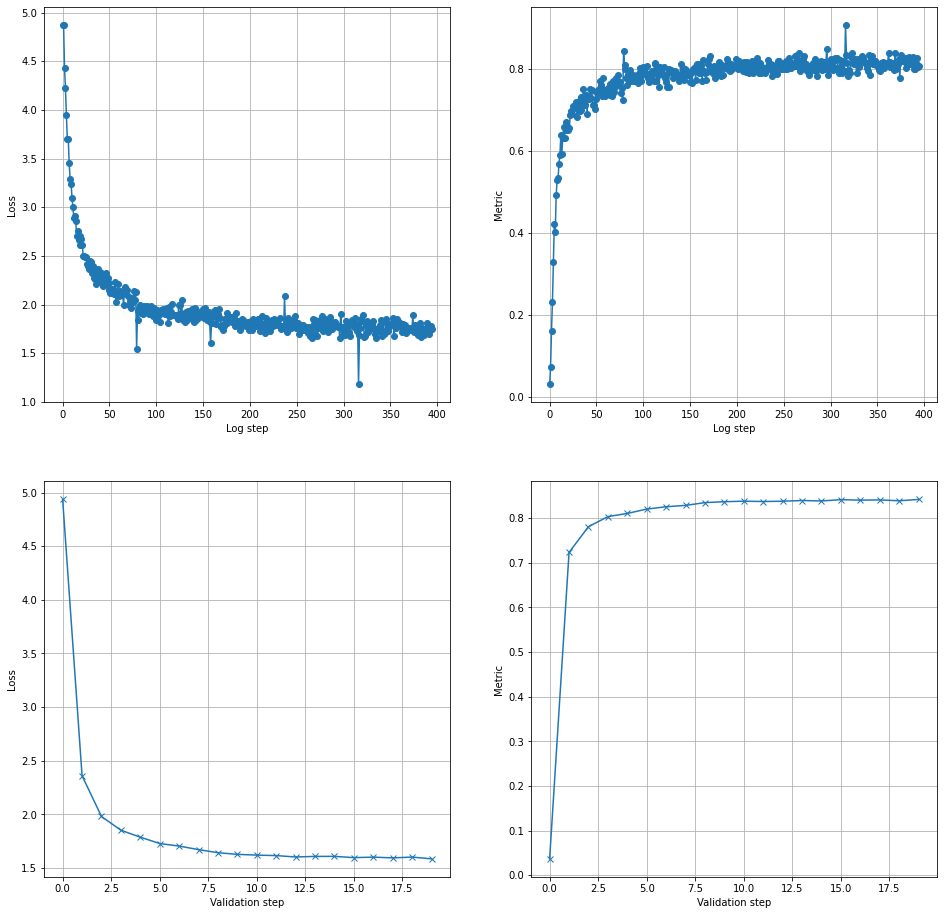

In [ ]:
for epoch in range(config['NUM_EPOCHS']):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_resnet_4,
        log_step = 30,
        scheduler=scheduler
    )

In [ ]:
with open('logger_resnet_4','wb') as f:
    pickle.dump(logger_resnet_4.stats, f )

#### VGG

In [ ]:
model = load_model("vgg")
        
for param in model.parameters():
    param.required_grad = True
model = model.to(config['DEVICE'])

optim = torch.optim.Adam([{'params': model.features.parameters(), 'lr':config["LR"] / 10}, 
                          {'params': model.classifier.parameters()}], lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_vgg_4 = Logger('VGG')
logger_vgg_4.add_stat('train_loss')
logger_vgg_4.add_stat('train_metric')
logger_vgg_4.add_stat('test_loss')
logger_vgg_4.add_stat('test_metric')

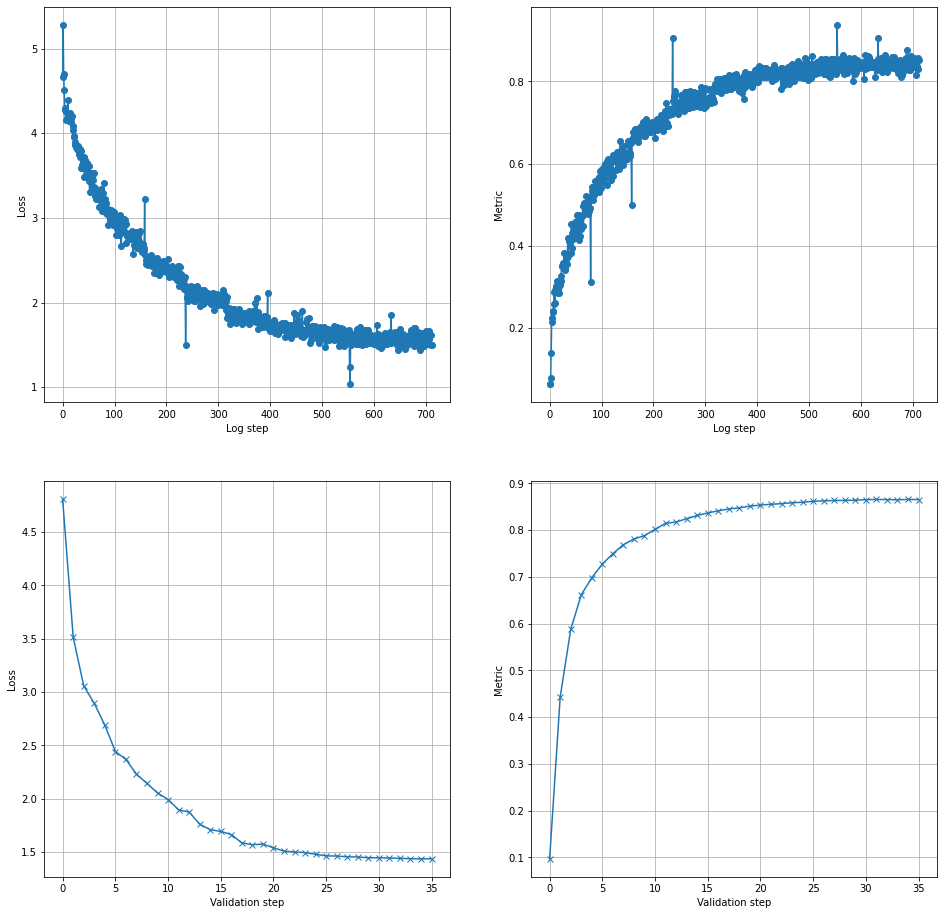

In [ ]:
for epoch in range(2):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_vgg_4,
        log_step = 30,
        scheduler=scheduler
    )

In [ ]:
with open('logger_vgg_4','wb') as f:
    pickle.dump(logger_vgg_4.stats, f )

#### Сравним разные архитектуры (LR для backbone в 10 уменьшен)

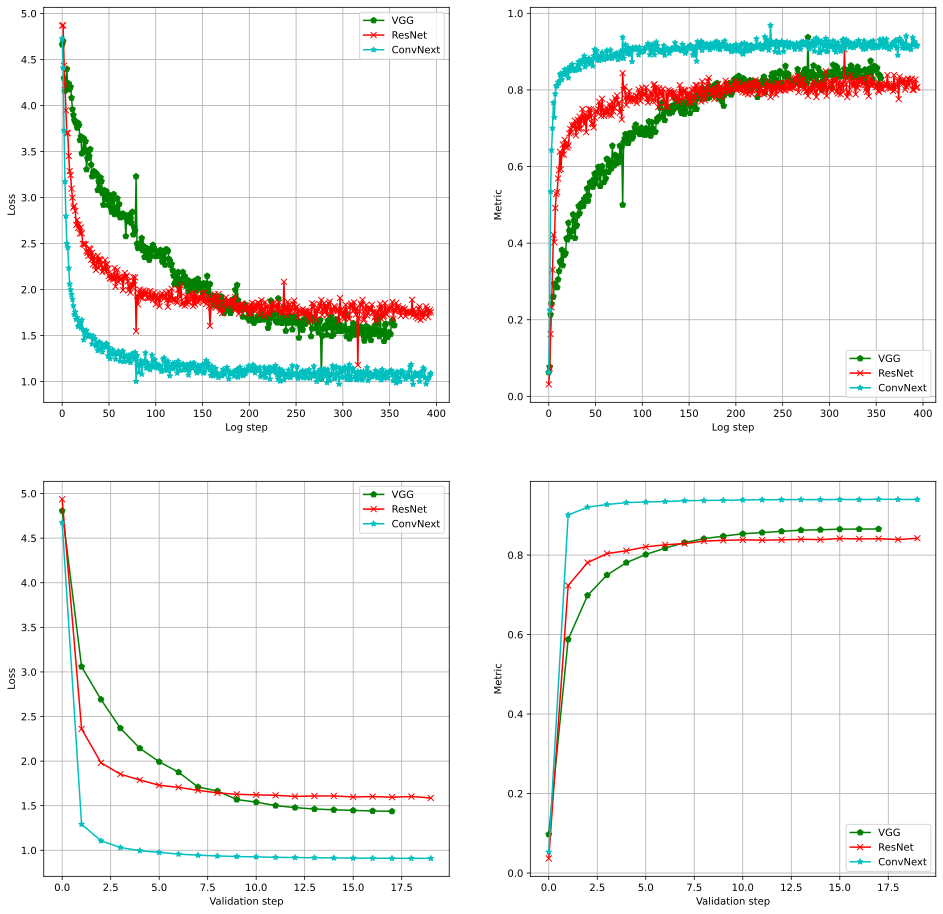

In [71]:
plot_results([logger_vgg_4, logger_resnet_4, logger_convnext_4])

### Уменьшим темп обучения еще в 10 раз

#### VGG

In [ ]:
model = load_model("vgg")
        
for param in model.parameters():
    param.required_grad = True
model = model.to(config['DEVICE'])

optim = torch.optim.Adam([{'params': model.features.parameters(), 'lr':config["LR"] / 100}, 
                          {'params': model.classifier.parameters()}], lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_vgg_5 = Logger('VGG')
logger_vgg_5.add_stat('train_loss')
logger_vgg_5.add_stat('train_metric')
logger_vgg_5.add_stat('test_loss')
logger_vgg_5.add_stat('test_metric')

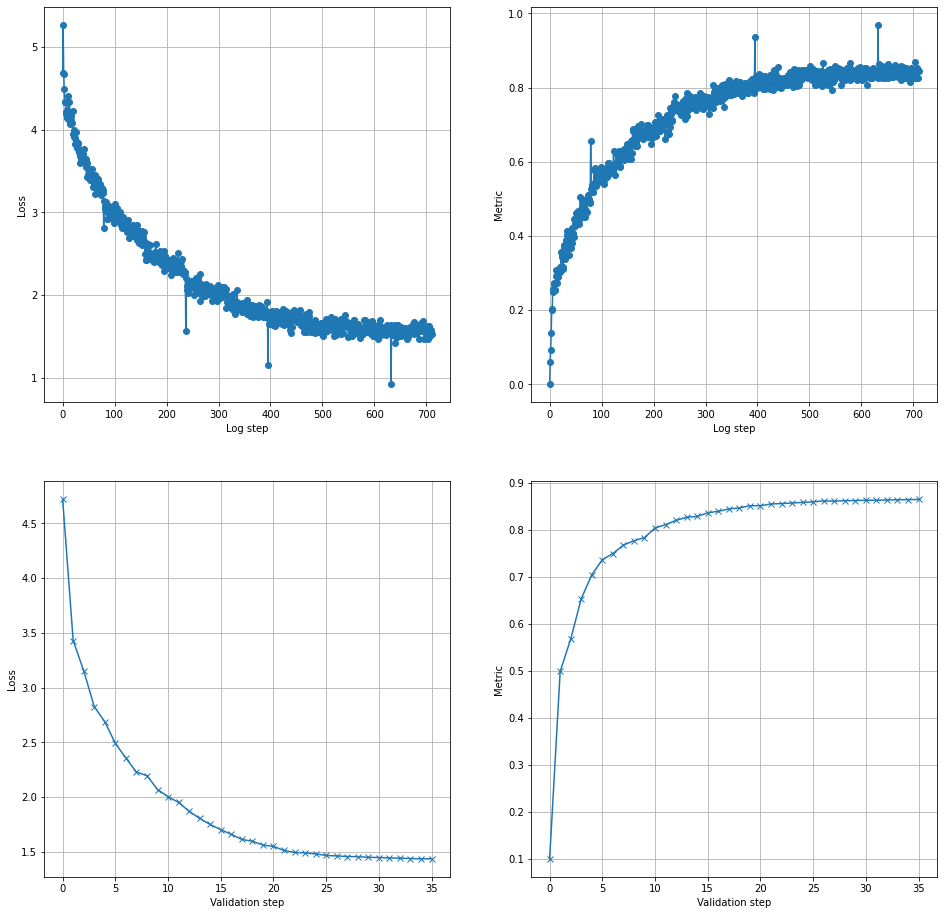

In [ ]:
for epoch in range(9):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_vgg_5,
        log_step = 30,
        scheduler=scheduler
    )

In [ ]:
with open('logger_vgg_5','wb') as f:
    pickle.dump(logger_vgg_5.stats, f )

#### ResNet

In [ ]:
model = load_model("resnet")

feature_extract = []
for name, param in model.named_parameters():
    if name[:2] != 'fc':
        feature_extract.append(param)
        
for param in model.parameters():
    param.required_grad = True
model = model.to(config['DEVICE'])

optim = torch.optim.Adam([{'params': feature_extract, 'lr':config["LR"] / 100}, 
                          {'params': model.fc.parameters()}], lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_resnet_5 = Logger('ResNet')
logger_resnet_5.add_stat('train_loss')
logger_resnet_5.add_stat('train_metric')
logger_resnet_5.add_stat('test_loss')
logger_resnet_5.add_stat('test_metric')

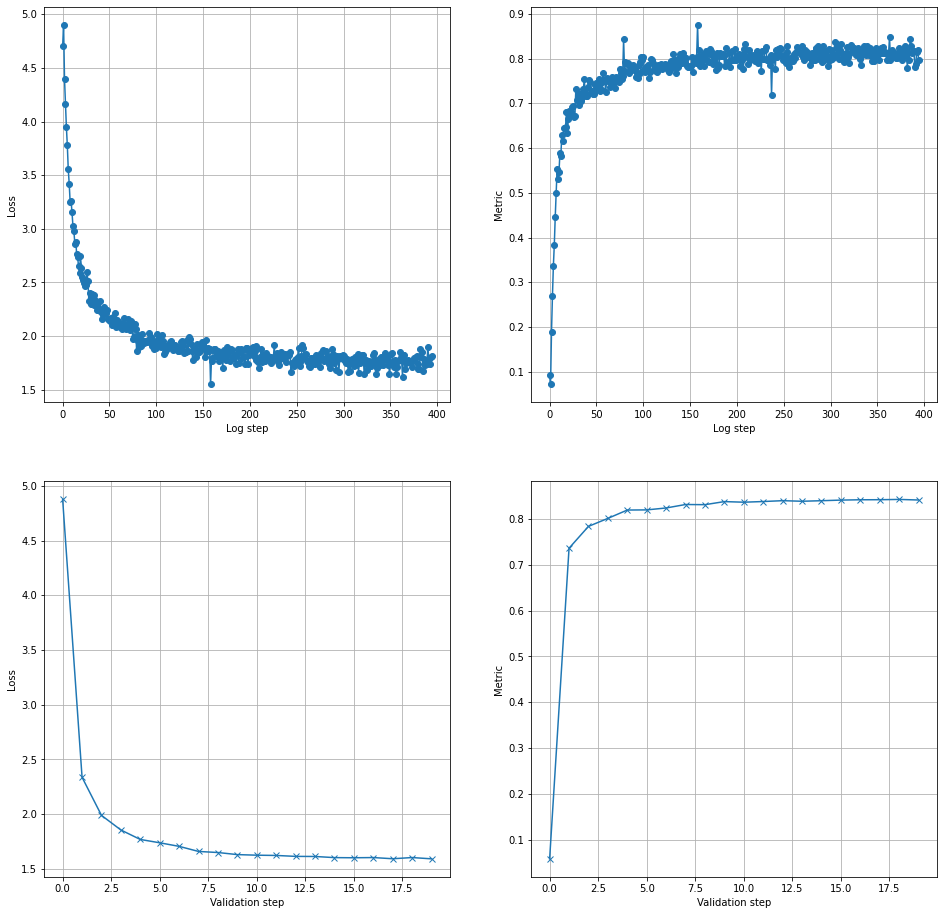

In [ ]:
for epoch in range(config['NUM_EPOCHS']):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_resnet_5,
        log_step = 30,
        scheduler=scheduler
    )

In [ ]:
with open('logger_resnet_5','wb') as f:
    pickle.dump(logger_resnet_5.stats, f )

#### ConvNext

In [ ]:
model = load_model("convnext")
for param in model.parameters():
    param.required_grad = True
model = model.to(config['DEVICE'])
optim = torch.optim.Adam([{'params': model.features.parameters(), 'lr': config["LR"] / 100}, 
                         {'params': model.classifier.parameters()}], lr=config["LR"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=300, 
                                            gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
logger_convnext_5 = Logger('ConvNext')
logger_convnext_5.add_stat('train_loss')
logger_convnext_5.add_stat('train_metric')
logger_convnext_5.add_stat('test_loss')
logger_convnext_5.add_stat('test_metric')

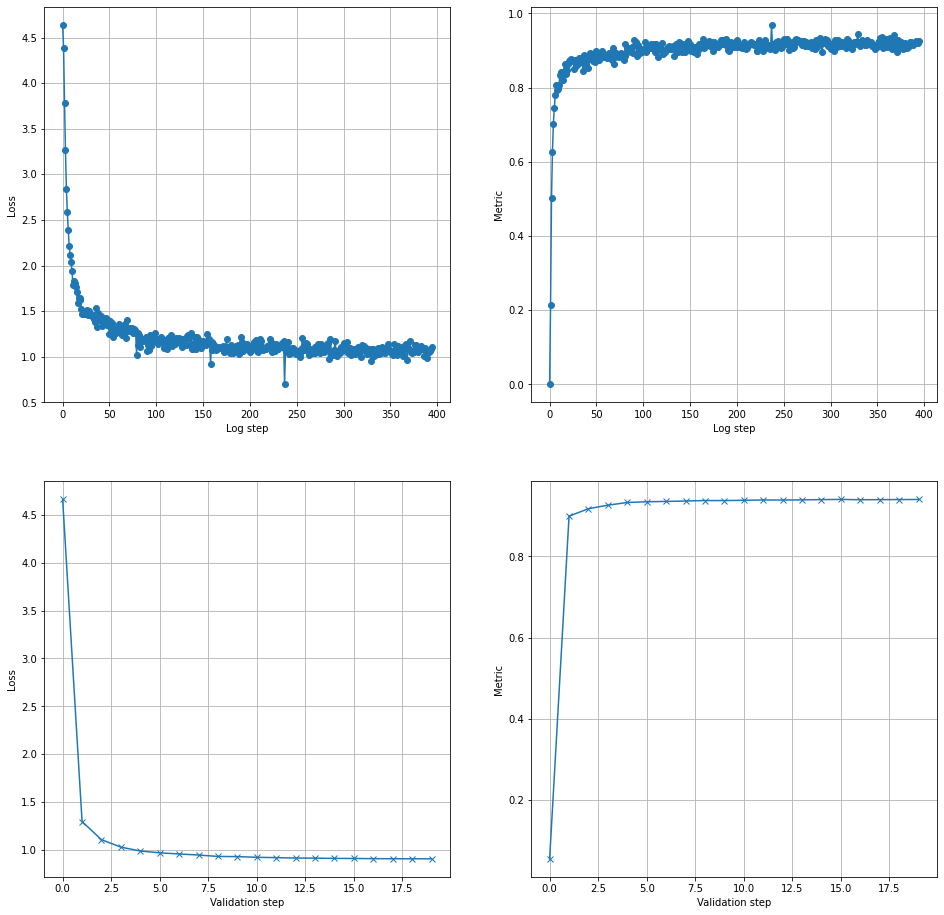

In [ ]:
for epoch in range(config['NUM_EPOCHS']):
    train_epoch(
        model, 
        criterion, 
        optim, 
        food_loader_train, 
        food_loader_test,
        partial(top_k_accuracy_score, k=5, labels=np.arange(0, 101)),
        config['DEVICE'],
        logger_convnext_5,
        log_step = 30,
        scheduler=scheduler
    )

In [ ]:
with open('logger_convnext_5','wb') as f:
    pickle.dump(logger_convnext_5.stats, f )

#### Cравним архитектуры между собой. (LR у backbone уменьшен в 100 раз)

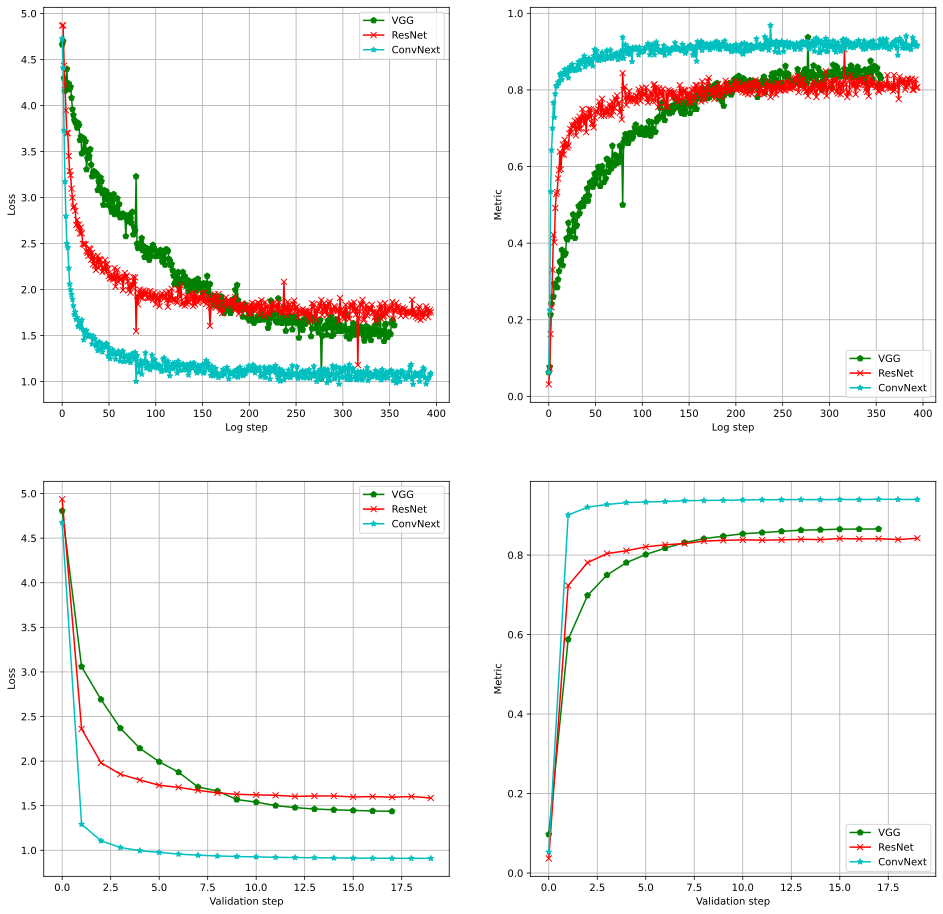

In [72]:
plot_results([logger_vgg_5, logger_resnet_5, logger_convnext_5])

### Промежуточные итоги
* `ConvNext` даже в самой младшей архитектуре дает результат на порядок лучший остальных сетей. Значительный gap заметен в абсолютно всех экспериментах. К тому же он сходится быстрее других. А значит за 7 лет сверточные сети прилично продвинулись вперед.
* `VGG` оказывается не хуже / лучше `ResNet`. Архитектурные отличия сетей довольно значительные и некоторые составляющие идут не в пользу первой, однако результаты сопоставимы. Хотя заметно явно, что `VGG` сильно проигрывает остальным сетям по скорости сходимости.

### Сравним методы для каждой из архитектур в отдельности

#### VGG

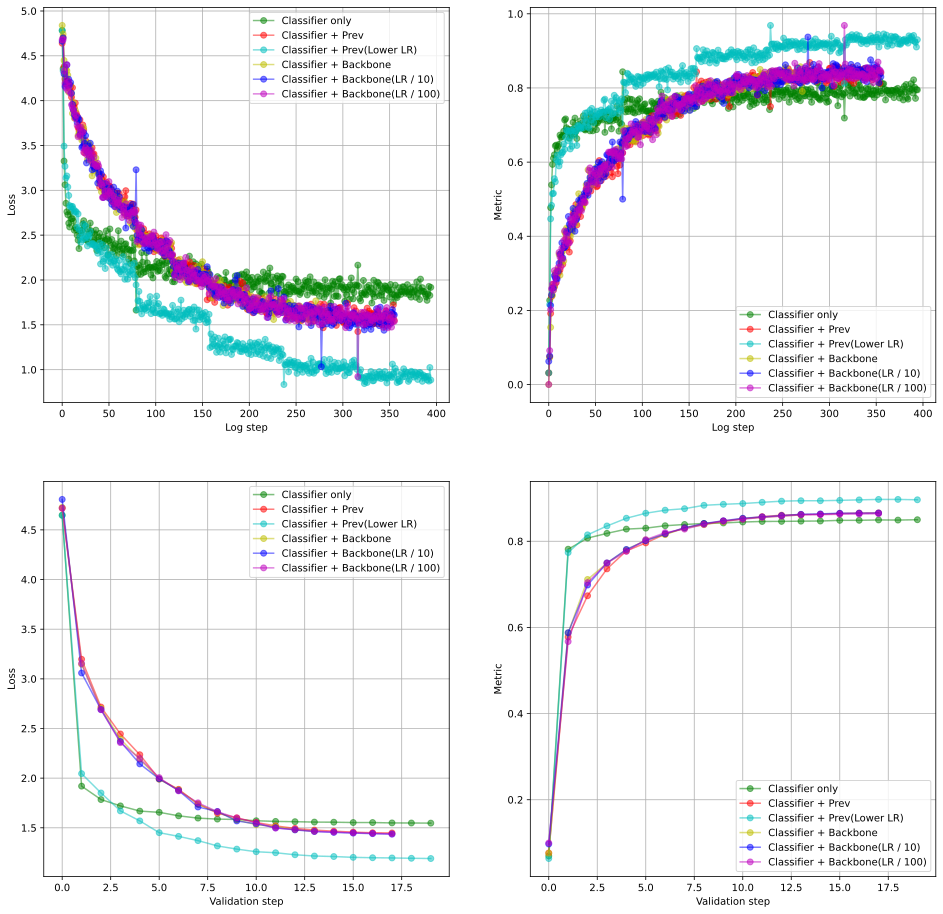

In [94]:
plot_results([logger_vgg, logger_vgg_1, logger_vgg_2, logger_vgg_3, logger_vgg_4, logger_vgg_5], pure_markers=False)

#### Рассмотрим внимательнее
Видим, что лучший результат и скорость сходимости оказываются у метода обучения линейного слоя с предыдущим на уменьшенном темпе обучения. Это говорит нам о том, что сеть уже была готова довольно хорошо решать подобную задачу и быстро адптировалась, в то время как файнтюн всей сети сильно затянулся. Нужно отметить, что даже обычным тюном классификатора модель сходилась быстро, но результат в итоге оказался посредственным, возможно, это говорит о том, что модель была готова решать задачу, но одному классификатору не хватило обобщающей способности. Полный файнтюн модели с разными темпами обучения сходится довольно долго и не к лучшему результату.

#### ResNet

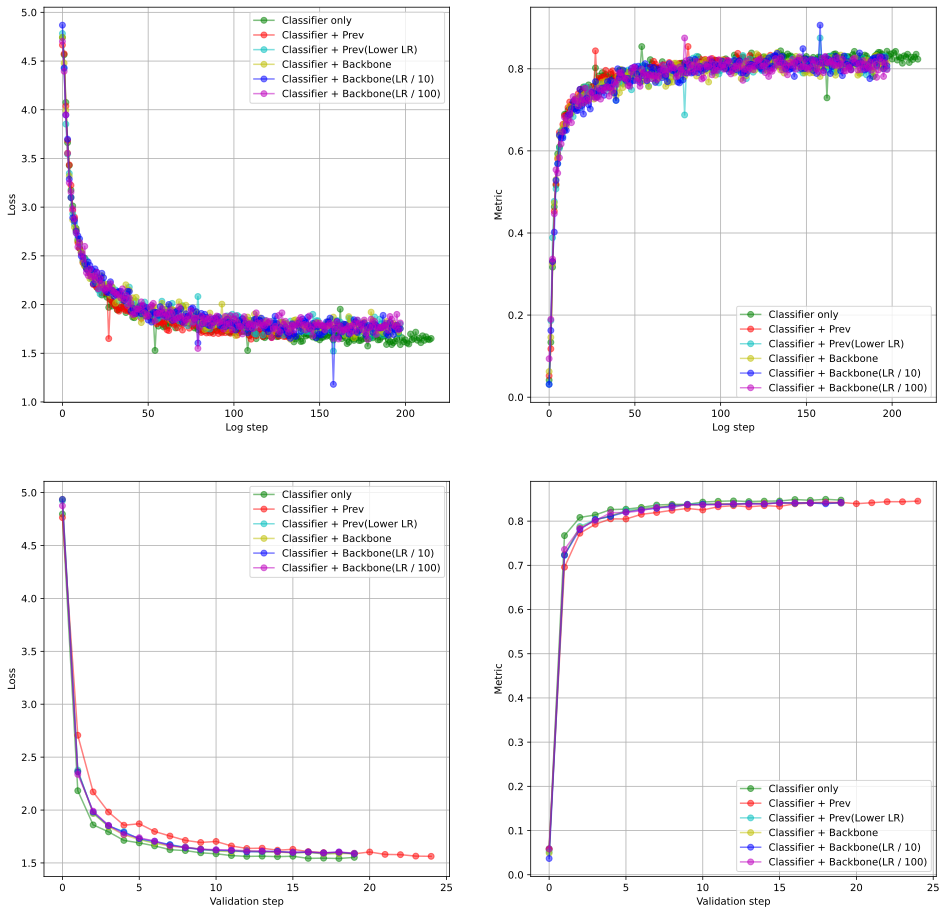

In [114]:
plot_results([logger_vgg, logger_vgg_1, logger_vgg_2, logger_vgg_3, logger_vgg_4, logger_vgg_5], pure_markers=False)

#### Рассмотрим внимательнее
Снова видим, что один классификатор или классификатор + предпоследний слой дают лучшие результаты и лучшие скорости сходимости. В отличие от `VGG` тут сложно выделить какой-то один метод, хотя в силу вычислительной простоты нужно отдать предпочтению тюну классификатора

#### ConvNext

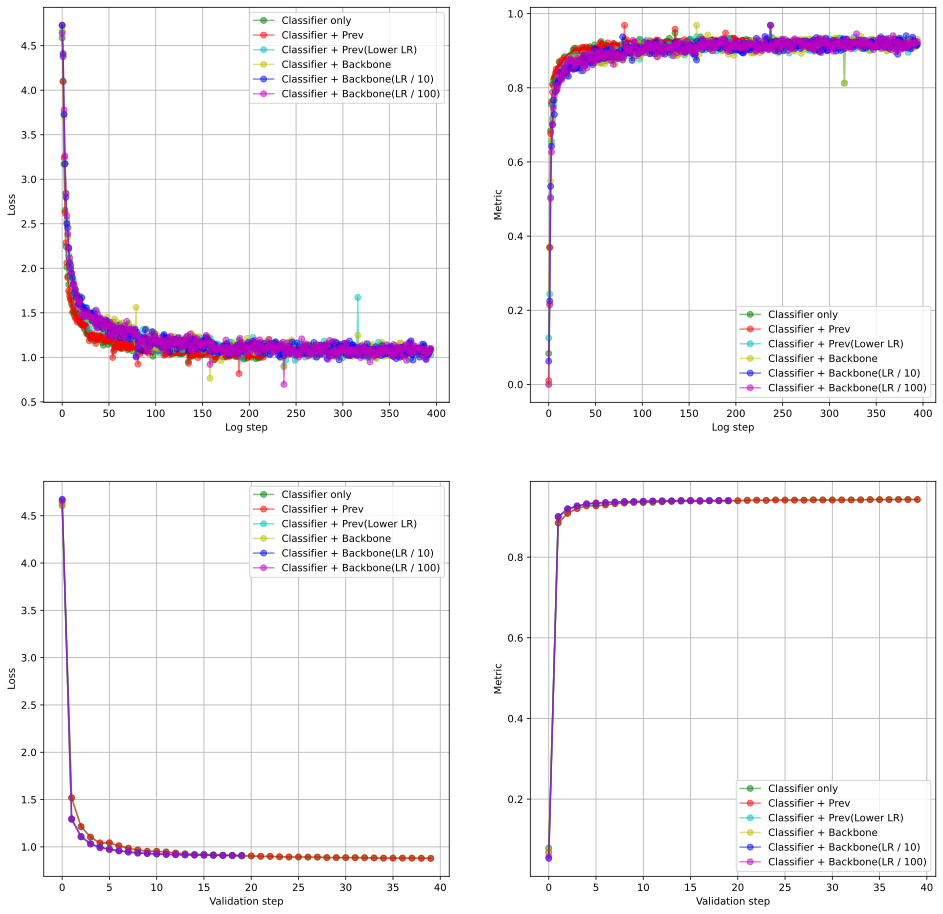

In [110]:
plot_results([logger_vgg, logger_vgg_1, logger_vgg_2, logger_vgg_3, logger_vgg_4, logger_vgg_5], pure_markers=False)

#### Рассмотрим внимательнее
В случае этой модели сложно сказать что-либо, по-видимому модель уже была отлично обучена(скор скачет со второй же валидации) и небольшой тюн параметров уже привел нас к отличным результатам. Здесь видимо приходится прибегать к тюну одного лишь классификатора для простоты вычислений.

## Подведем итоги
Мы рассмотрели 3 довольно разные архитектуры и несколько методов файнтюна моделей на нашей задаче. По итогам можно выделить следущие заключения:
* Использовать новые архитектуры лучше - быстрее сходятся и дают лучшее качество, хоть и весят иногда больше.
* Чаще всего тюна классификатора или классификатора + предпоследнего слоя хватает для того чтобы достаточно хорошо решить задачу, приложив минимум усилий.

Трансфер завершен! Спасибо, что были  с нами!